In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#pretrained_path = "/content/drive/MyDrive/unet_castlegate_20slices_pretrained.pth"
pretrained_path = "/content/drive/MyDrive/unet_castlegate_bentheimer_20slices_pretrained.pth"


In [ ]:
#DATA
import glob
import os

images_path = "/content/drive/MyDrive/Original Images"
masks_path  = "/content/drive/MyDrive/Original Masks"

image_files = sorted(glob.glob(os.path.join(images_path, "*.tif")))
mask_files  = sorted(glob.glob(os.path.join(masks_path, "*.tif")))

print(f"Found {len(image_files)} images and {len(mask_files)} masks")

Found 22 images and 22 masks


In [ ]:
# 2. DATASET CLASS AND TRANSFORMS

class SegmentationDataset(Dataset):
    def __init__(self, image_files, mask_files, transform=None, mask_transform=None):
        self.image_files = image_files
        self.mask_files = mask_files
        self.transform = transform
        self.mask_transform = mask_transform
        assert len(self.image_files) == len(self.mask_files), "Mismatch between images and masks"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        mask_path = self.mask_files[idx]

        # --- THIS IS THE FIX ---
        # Load BOTH as-is (float images), do NOT use .convert()
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        # --- END FIX ---

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

import numpy as np

# 1. NEW IMAGE TRANSFORM

# This transform will resize, then perform min-max normalization
# to stretch the contrast, just like your example code.

def normalize_image_transform(img):
    """Normalize image to [0,1] by /255, igual que en el pretrain."""
    np_img = np.array(img, dtype=np.float32)
    np_img = np_img / 255.0
    return torch.from_numpy(np_img).unsqueeze(0)


image_transform = transforms.Compose([
    # Use BILINEAR for resizing real images (looks better)
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Lambda(normalize_image_transform)
])

# 2. MASK TRANSFORM (Stays the same as before)

# This transform resizes, then converts the float data to a binary
# 0/1 mask based on a threshold (pixel > 0)

mask_transform = transforms.Compose([
    # Use NEAREST for resizing masks (preserves labels)
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Lambda(lambda img: torch.from_numpy(np.array(img) <= 0).unsqueeze(0).float())
])

# 1. Create a temporary dataset instance to test the transforms
print("Visualizing samples from the Dataset (after transforms)...")
viz_dataset = SegmentationDataset(
    image_files=image_files,
    mask_files=mask_files,
    transform=image_transform,
    mask_transform=mask_transform
)

# 2. Plot the first 3 samples
n_samples_to_plot = 3
plt.figure(figsize=(6, n_samples_to_plot * 4))

for i in range(n_samples_to_plot):
    # Get the transformed image and mask tensors
    image_tensor, mask_tensor = viz_dataset[i]

    # Squeeze() removes the channel dimension [1, 256, 256] -> [256, 256]
    # .numpy() converts the tensor for plotting

    # a) Transformed Image
    plt.subplot(n_samples_to_plot, 2, i*2 + 1)
    plt.imshow(image_tensor.squeeze().numpy(), cmap='gray')
    plt.title(f"Sample {i}: Transformed Image\nShape: {image_tensor.shape}")
    plt.axis('off')

    # b) Transformed (Thresholded) Mask
    plt.subplot(n_samples_to_plot, 2, i*2 + 2)
    plt.imshow(mask_tensor.squeeze().numpy(), cmap='gray')
    plt.title(f"Sample {i}: Transformed Mask\nShape: {mask_tensor.shape}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# --- ADDED: Pixel Count for a Single Mask ---
print("\n--- Analyzing Pixel Counts for a Single Mask (Sample 0) ---")

# 1. Get a single sample (the first one) from the dataset
# This applies the mask_transform, so the mask is already 0s and 1s
image_tensor, mask_tensor = viz_dataset[0]

# 2. Count the pixels
#    .sum() adds up all the 1.0s
pore_pixels = mask_tensor.sum().item()

#    .numel() gets the total number of elements
total_pixels = mask_tensor.numel()

#    The rest must be 0.0s
background_pixels = total_pixels - pore_pixels

# 3. Print the results
pore_percentage = (pore_pixels / total_pixels) * 100
bg_percentage = (background_pixels / total_pixels) * 100

print(f"Analyzing Sample 0 (after transforms):")
print(f"Total Pixels: {int(total_pixels)}")
print(f"Pore (1.0) Pixels:   {int(pore_pixels)} ({pore_percentage:.2f}%)")
print(f"Background (0.0) Pixels: {int(background_pixels)} ({bg_percentage:.2f}%)")

NameError: name 'Dataset' is not defined

In [ ]:
#no estoy segura que se tenga q plotear:
# 3. DATASET SPLITTING AND DATALOADERS
full_dataset = SegmentationDataset(
    image_files=image_files,
    mask_files=mask_files,
    transform=image_transform,
    mask_transform=mask_transform
)

# Split
torch.manual_seed(42) # for reproducible splits
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

print(f"Total samples: {total_size}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Test samples: {test_size}")

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

# Dataloaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("\nDataLoaders created.")

NameError: name 'SegmentationDataset' is not defined

In [ ]:
# 4. SANITY CHECK
try:
    images, masks = next(iter(train_loader))
    print(f"Images batch shape: {images.shape}")  # Should be [B, 1, 256, 256]
    print(f"Masks batch shape:  {masks.shape}")   # Should be [B, 1, 256, 256]
    print(f"Mask tensor data type: {masks.dtype}")
    print(f"Mask min value: {masks.min()}")
    print(f"Mask max value: {masks.max()}")
    print(f"Unique mask values in batch: {torch.unique(masks)}")
except (StopIteration, NameError):
    print("ERROR: Could not fetch a batch from train_loader. Check data paths/splitting.")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(Conv → BatchNorm → ReLU) * 2, stored in .net to match checkpoint keys"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.net(x)


class UNet(nn.Module):
    """
    U-Net with channel sizes matching the pretrained model:
      down1:  1   ->  32
      down2: 32   ->  64
      down3: 64   -> 128
      down4: 128  -> 256
      down5: 256  -> 512 (bottleneck)
    And symmetric decoder.
    """
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        # ------ Encoder (same channels as checkpoint) ------
        self.down1 = DoubleConv(in_channels, 32)
        self.down2 = DoubleConv(32, 64)
        self.down3 = DoubleConv(64, 128)
        self.down4 = DoubleConv(128, 256)

        # Bottleneck
        self.down5 = DoubleConv(256, 512)

        # ------ Decoder ------
        self.up4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(256 + 256, 256)   # cat(skip 256, up 256) = 512

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(128 + 128, 128)

        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(64 + 64, 64)

        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(32 + 32, 32)

        # Final 1x1 conv
        self.final = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.down1(x)
        x2 = self.down2(F.max_pool2d(x1, 2))
        x3 = self.down3(F.max_pool2d(x2, 2))
        x4 = self.down4(F.max_pool2d(x3, 2))

        # Bottleneck
        x5 = self.down5(F.max_pool2d(x4, 2))

        # Decoder
        x = self.up4(x5)
        x = torch.cat([x4, x], dim=1)
        x = self.conv4(x)

        x = self.up3(x)
        x = torch.cat([x3, x], dim=1)
        x = self.conv3(x)

        x = self.up2(x)
        x = torch.cat([x2, x], dim=1)
        x = self.conv2(x)

        x = self.up1(x)
        x = torch.cat([x1, x], dim=1)
        x = self.conv1(x)

        x = self.final(x)
        return x

print("UNet compatible with pretrained checkpoint defined correctly.")


UNet compatible with pretrained checkpoint defined correctly.


In [ ]:
# 3. DATASET SPLITTING AND DATALOADERS
full_dataset = SegmentationDataset(
    image_files=image_files,
    mask_files=mask_files,
    transform=image_transform,
    mask_transform=mask_transform
)

# Split
torch.manual_seed(42) # for reproducible splits
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

print(f"Total samples: {total_size}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Test samples: {test_size}")

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

# Dataloaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("\nDataLoaders created.")

NameError: name 'SegmentationDataset' is not defined

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Create the same UNet architecture (must match the checkpoint!)
model = UNet(in_channels=1, out_channels=1).to(device)

# 2. Load pretrained weights
print(f"Loading pretrained weights from: {pretrained_path}")
state_dict = torch.load(pretrained_path, map_location=device)

# Load state dict (now shapes should match)


# 3. Define optimizer as usual (we still train ALL layers)
learning_rate = 0.001
opt = optim.Adam(model.parameters(), learning_rate)

# 4. Choose loss function as before
loss_fn = DiceLoss()
print(f"Using loss function: {loss_fn.__class__.__name__}")
epochs = 20


In [ ]:
# Lists to store losses
train_losses = []
val_losses = []

print("\nStarting training...")

for epoch in range(epochs):
    tic = time()

    # ---- DESCONGELAR ENCÓDER EN EPOCH 5 ----
    if epoch == 5:
        print("Unfreezing encoder AND switching optimizer to train all layers...")
        for name, param in model.named_parameters():
            param.requires_grad = True
        opt = optim.Adam(model.parameters(), lr=1e-4)

    # Training Phase
    model.train()

    avg_loss = 0
    for X_batch, y_true in train_loader:
        X_batch = X_batch.to(device)
        y_true = y_true.to(device)

        opt.zero_grad()
        y_pred_logits = model(X_batch)
        loss = loss_fn(y_pred_logits, y_true)
        loss.backward()
        opt.step()
        avg_loss += loss.item() / len(train_loader)

    # Validation Phase
    model.eval()
    avg_val_loss = 0
    with torch.no_grad():
        for X_batch, y_true in val_loader:
            X_batch = X_batch.to(device)
            y_true = y_true.to(device)
            y_pred_logits = model(X_batch)
            val_loss = loss_fn(y_pred_logits, y_true)
            avg_val_loss += val_loss.item() / len(val_loader)

    toc = time()
    print(f'* Epoch {epoch+1:02d}/{epochs} (Time: {toc-tic:.2f}s)')
    print(f'  - Train Loss: {avg_loss:.4f}')
    print(f'  - Val Loss:   {avg_val_loss:.4f}')

    # Append losses to lists
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)

print("\nTraining finished!")

# 8. PLOTTING THE LOSSES
# Create an array of epoch numbers (e.g., [1, 2, ..., 20])
epoch_count = range(1, epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epoch_count, train_losses, 'r-o', label='Training Loss')
plt.plot(epoch_count, val_losses, 'b-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.ylim([0,1])
plt.grid(True)
plt.show()


In [ ]:
#res = model.load_state_dict(state_dict, strict=False)
#print("Pretrained weights loaded!")
#print("Missing keys:", res.missing_keys)
#print("Unexpected keys:", res.unexpected_keys)


## todo junto por lo que sea

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 22 images and 22 masks
Visualizing samples from the Dataset (after transforms)...


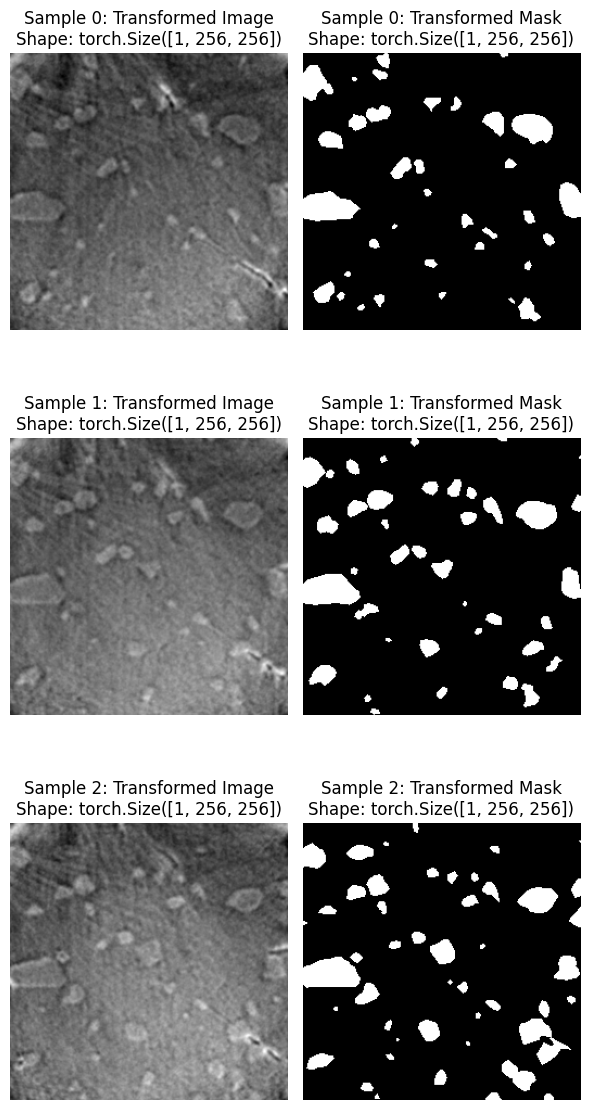


--- Analyzing Pixel Counts for a Single Mask (Sample 0) ---
Total Pixels: 65536
Pore (1.0) Pixels:   6211 (9.48%)
Background (0.0) Pixels: 59325 (90.52%)
Total samples: 22
Training samples: 17
Validation samples: 2
Test samples: 3

DataLoaders created.
Images batch shape: torch.Size([8, 1, 256, 256])
Masks batch shape:  torch.Size([8, 1, 256, 256])
Mask tensor data type: torch.float32
Mask min value: 0.0
Mask max value: 1.0
Unique mask values in batch: tensor([0., 1.])
UNet compatible with pretrained checkpoint defined correctly.
Using device: cuda
Loading pretrained weights from: /content/drive/MyDrive/unet_castlegate_bentheimer_20slices_pretrained.pth
Pretrained weights loaded!
Missing keys: []
Unexpected keys: []
Using loss function: DiceLoss

Starting training...
* Epoch 01/50 (Time: 0.85s)
  - Train Loss: 0.7577
  - Val Loss:   0.7928
* Epoch 02/50 (Time: 0.72s)
  - Train Loss: 0.7496
  - Val Loss:   0.7828
* Epoch 03/50 (Time: 0.71s)
  - Train Loss: 0.7419
  - Val Loss:   0.7711

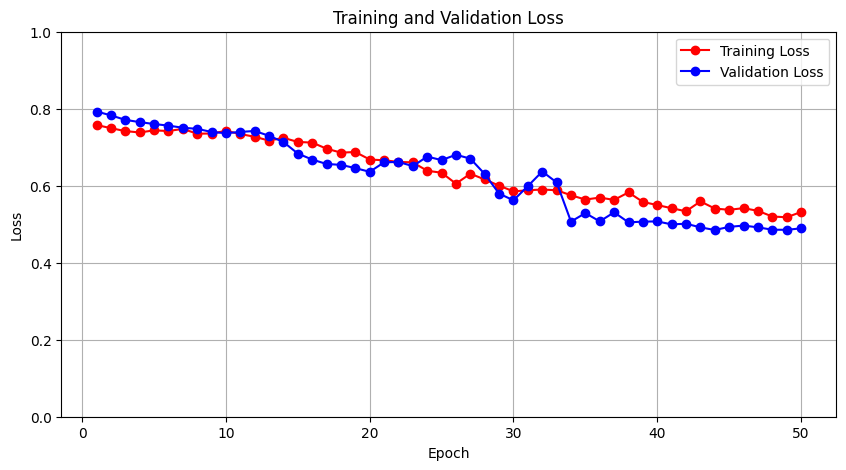

In [ ]:
# -------------------------
# 0. Imports and Drive
# -------------------------
from google.colab import drive
drive.mount('/content/drive')

import os
import glob
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from time import time
import torch.optim as optim

#pretrained_path = "/content/drive/MyDrive/unet_castlegate_20slices_pretrained.pth"
pretrained_path = "/content/drive/MyDrive/unet_castlegate_bentheimer_20slices_pretrained.pth"
# -------------------------
# 1. Data paths
# -------------------------
images_path = "/content/drive/MyDrive/Original Images"
masks_path  = "/content/drive/MyDrive/Original Masks"

image_files = sorted(glob.glob(os.path.join(images_path, "*.tif")))
mask_files  = sorted(glob.glob(os.path.join(masks_path, "*.tif")))

print(f"Found {len(image_files)} images and {len(mask_files)} masks")

# -------------------------
# 2. Dataset and transforms
# -------------------------
class SegmentationDataset(Dataset):
    def __init__(self, image_files, mask_files, transform=None, mask_transform=None):
        self.image_files = image_files
        self.mask_files = mask_files
        self.transform = transform
        self.mask_transform = mask_transform
        assert len(self.image_files) == len(self.mask_files), "Mismatch between images and masks"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        mask_path = self.mask_files[idx]

        image = Image.open(img_path)
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

def normalize_image_transform(img):
    """Normalizes a float PIL image to a [0, 1] tensor."""
    np_img = np.array(img, dtype=np.float32)

    min_val = np.min(np_img)
    max_val = np.max(np_img)

    if max_val - min_val > 1e-6:
        normalized_img = (np_img - min_val) / (max_val - min_val)
    else:
        normalized_img = np.zeros(np_img.shape, dtype=np.float32)

    return torch.from_numpy(normalized_img).unsqueeze(0)

image_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.Lambda(normalize_image_transform)
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Lambda(lambda img: torch.from_numpy((np.array(img) <= 0).astype(np.float32)).unsqueeze(0))
])

# Visual sanity check
print("Visualizing samples from the Dataset (after transforms)...")
viz_dataset = SegmentationDataset(
    image_files=image_files,
    mask_files=mask_files,
    transform=image_transform,
    mask_transform=mask_transform
)

n_samples_to_plot = 3
plt.figure(figsize=(6, n_samples_to_plot * 4))

for i in range(n_samples_to_plot):
    image_tensor, mask_tensor = viz_dataset[i]

    plt.subplot(n_samples_to_plot, 2, i*2 + 1)
    plt.imshow(image_tensor.squeeze().numpy(), cmap='gray')
    plt.title(f"Sample {i}: Transformed Image\nShape: {image_tensor.shape}")
    plt.axis('off')

    plt.subplot(n_samples_to_plot, 2, i*2 + 2)
    plt.imshow(mask_tensor.squeeze().numpy(), cmap='gray')
    plt.title(f"Sample {i}: Transformed Mask\nShape: {mask_tensor.shape}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Pixel distribution for sample 0
print("\n--- Analyzing Pixel Counts for a Single Mask (Sample 0) ---")
_, mask_tensor = viz_dataset[0]
pore_pixels = mask_tensor.sum().item()
total_pixels = mask_tensor.numel()
bg_pixels = total_pixels - pore_pixels
pore_percentage = (pore_pixels / total_pixels) * 100
bg_percentage = (bg_pixels / total_pixels) * 100
print(f"Total Pixels: {int(total_pixels)}")
print(f"Pore (1.0) Pixels:   {int(pore_pixels)} ({pore_percentage:.2f}%)")
print(f"Background (0.0) Pixels: {int(bg_pixels)} ({bg_percentage:.2f}%)")

# -------------------------
# 3. Dataset split and loaders
# -------------------------
full_dataset = SegmentationDataset(
    image_files=image_files,
    mask_files=mask_files,
    transform=image_transform,
    mask_transform=mask_transform
)

torch.manual_seed(42)
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

print(f"Total samples: {total_size}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Test samples: {test_size}")

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("\nDataLoaders created.")

try:
    images, masks = next(iter(train_loader))
    print(f"Images batch shape: {images.shape}")
    print(f"Masks batch shape:  {masks.shape}")
    print(f"Mask tensor data type: {masks.dtype}")
    print(f"Mask min value: {masks.min()}")
    print(f"Mask max value: {masks.max()}")
    print(f"Unique mask values in batch: {torch.unique(masks)}")
except Exception as e:
    print("ERROR fetching batch:", e)

# -------------------------
# 4. UNet architecture (32-64-128-256-512)
# -------------------------
class DoubleConv(nn.Module):
    """(Conv → BatchNorm → ReLU) * 2, stored in .net to match checkpoint keys"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.net(x)


class UNet(nn.Module):

    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        self.down1 = DoubleConv(in_channels, 32)
        self.down2 = DoubleConv(32, 64)
        self.down3 = DoubleConv(64, 128)
        self.down4 = DoubleConv(128, 256)
        self.down5 = DoubleConv(256, 512)

        self.up4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(256 + 256, 256)

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(128 + 128, 128)

        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(64 + 64, 64)

        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(32 + 32, 32)

        self.final = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(F.max_pool2d(x1, 2))
        x3 = self.down3(F.max_pool2d(x2, 2))
        x4 = self.down4(F.max_pool2d(x3, 2))

        x5 = self.down5(F.max_pool2d(x4, 2))

        x = self.up4(x5)
        x = torch.cat([x4, x], dim=1)
        x = self.conv4(x)

        x = self.up3(x)
        x = torch.cat([x3, x], dim=1)
        x = self.conv3(x)

        x = self.up2(x)
        x = torch.cat([x2, x], dim=1)
        x = self.conv2(x)

        x = self.up1(x)
        x = torch.cat([x1, x], dim=1)
        x = self.conv1(x)

        x = self.final(x)
        return x

print("UNet compatible with pretrained checkpoint defined correctly.")

# -------------------------
# 5. Loss, model, optimizer, load pretrained
# -------------------------
class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, y_pred, y_true):
        y_true = y_true.float()
        p = torch.sigmoid(y_pred)
        if p.dim() == 3:
            p = p.unsqueeze(1)
            y_true = y_true.unsqueeze(1)
        elif y_true.dim() == 3:
            y_true = y_true.unsqueeze(1)
        N = p.shape[0]
        p_f = p.contiguous().view(N, -1)
        y_f = y_true.contiguous().view(N, -1)
        smooth = 1.0
        intersection = (p_f * y_f).sum(dim=1)
        denom = p_f.sum(dim=1) + y_f.sum(dim=1)
        dice = (2.0 * intersection + smooth) / (denom + smooth)
        return (1.0 - dice).mean()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = UNet(in_channels=1, out_channels=1).to(device)

print(f"Loading pretrained weights from: {pretrained_path}")
state_dict = torch.load(pretrained_path, map_location=device)
res = model.load_state_dict(state_dict, strict=False)
print("Pretrained weights loaded!")
print("Missing keys:", res.missing_keys)
print("Unexpected keys:", res.unexpected_keys)
# frezze encoder
for name, param in model.named_parameters():
    if name.startswith("down"):
        param.requires_grad = False

learning_rate = 1e-4 #
opt = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

#learning_rate = 1e-3
#opt = optim.Adam(model.parameters(), learning_rate)
loss_fn = DiceLoss()
epochs = 50 ###############
print(f"Using loss function: {loss_fn.__class__.__name__}")

# -------------------------
# 6. Training loop
# -------------------------
train_losses = []
val_losses = []

print("\nStarting training...")

for epoch in range(epochs):
    tic = time()

    # ---- DESCONGELAR ENCÓDER EN EPOCH 5 ----
    if epoch == 10:
        print("Unfreezing encoder AND switching optimizer to train all layers...")
        for name, param in model.named_parameters():
            param.requires_grad = True
        opt = optim.Adam(model.parameters(), lr=1e-4)

    # Training Phase
    model.train()

    avg_loss = 0
    for X_batch, y_true in train_loader:
        X_batch = X_batch.to(device)
        y_true = y_true.to(device)

        opt.zero_grad()
        y_pred_logits = model(X_batch)
        loss = loss_fn(y_pred_logits, y_true)
        loss.backward()
        opt.step()
        avg_loss += loss.item() / len(train_loader)

    # Validation Phase
    model.eval()
    avg_val_loss = 0
    with torch.no_grad():
        for X_batch, y_true in val_loader:
            X_batch = X_batch.to(device)
            y_true = y_true.to(device)
            y_pred_logits = model(X_batch)
            val_loss = loss_fn(y_pred_logits, y_true)
            avg_val_loss += val_loss.item() / len(val_loader)

    toc = time()
    print(f'* Epoch {epoch+1:02d}/{epochs} (Time: {toc-tic:.2f}s)')
    print(f'  - Train Loss: {avg_loss:.4f}')
    print(f'  - Val Loss:   {avg_val_loss:.4f}')

    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)

print("\nTraining finished!")

# -------------------------
# 7. Plot losses
# -------------------------
epoch_count = range(1, epochs + 1)
plt.figure(figsize=(10, 5))
plt.plot(epoch_count, train_losses, 'r-o', label='Training Loss')
plt.plot(epoch_count, val_losses,  'b-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.ylim([0,1])
plt.grid(True)
plt.show()



Starting evaluation on the test set...
Test Set Results (Averaged over 1 batches)
Pixel Accuracy (Rand): 84.06%
Dice Coefficient:      0.5485
Jaccard Index (IoU):   0.3779
Precision:             0.3907
Recall (Sensitivity):  0.9197

 Test Set Pixel Distribution (Ground Truth)
Total Pixels (all test masks): 196608
Total Pore (Foreground) Pixels: 20698 (10.53%)
Total Background Pixels:        175910 (89.47%)

Visualizing some test predictions...
Binary predictions - total positive pixels in batch: 48717.0
Sample 0:
  GT positive pixels:    7654.0
  Pred positive pixels:  15518.0
  Pred probs -> min / max / mean:  0.03793567419052124 1.0 0.27391189336776733
Sample 1:
  GT positive pixels:    6211.0
  Pred positive pixels:  13095.0
  Pred probs -> min / max / mean:  0.037612155079841614 1.0 0.24274402856826782
Sample 2:
  GT positive pixels:    6833.0
  Pred positive pixels:  20104.0
  Pred probs -> min / max / mean:  0.041614335030317307 1.0 0.33776000142097473


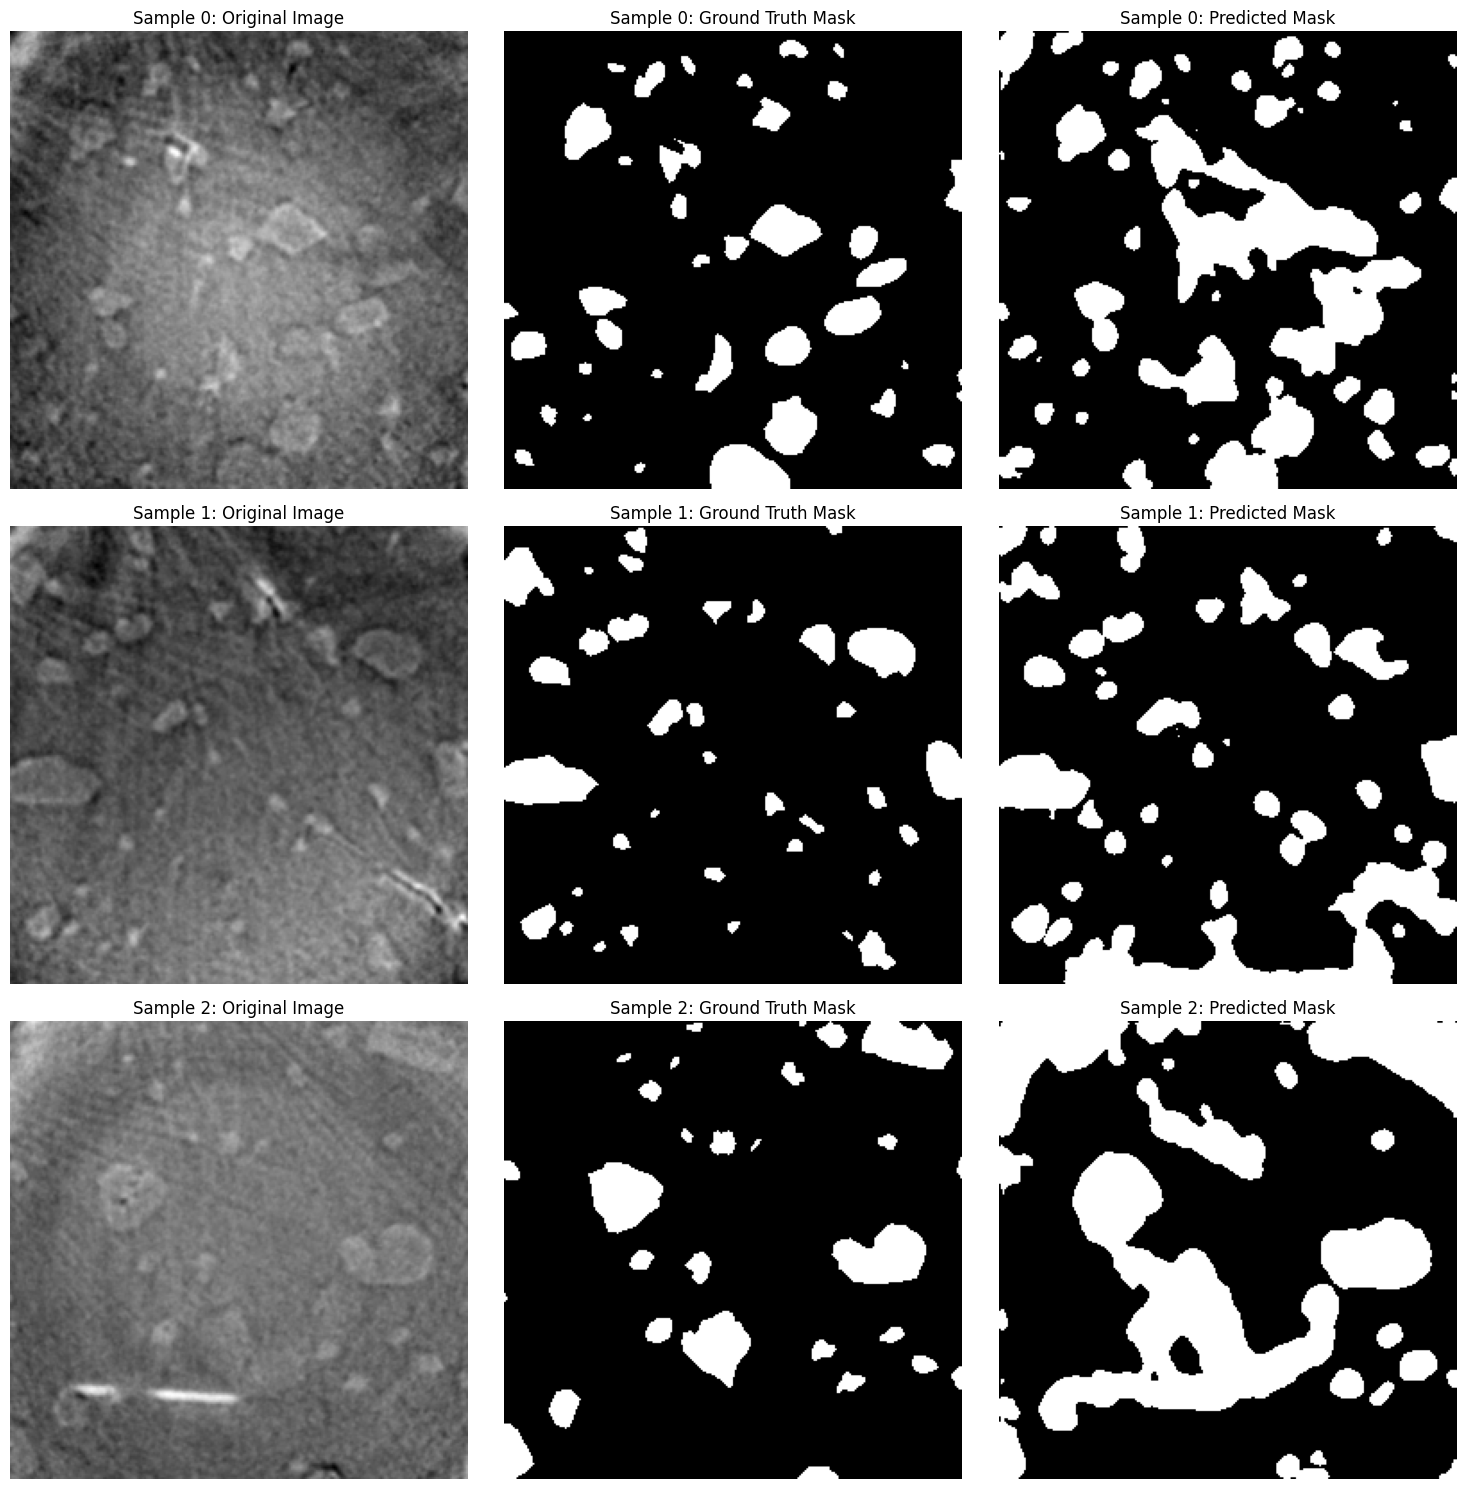

In [ ]:
# 1. SETUP FOR EVALUATION
model.eval()

# 2. METRIC FUNCTION
def calculate_all_metrics_batch(preds, y_true, smooth=1e-6):
    """
    Calculates all 5 metrics for a batch.
    Metrics are computed pixel-wise for the entire batch.
    """
    # Flatten tensors
    preds_f = preds.contiguous().view(-1).float()
    y_f = y_true.contiguous().view(-1).float()

    # Core Components
    tp = (preds_f * y_f).sum()
    fp = (preds_f * (1 - y_f)).sum()
    fn = ((1 - preds_f) * y_f).sum()
    tn = ((1 - preds_f) * (1 - y_f)).sum()
    total_pixels = y_f.numel()

    # Calculate Metrics
    precision = (tp + smooth) / (tp + fp + smooth)
    recall = (tp + smooth) / (tp + fn + smooth)
    accuracy = (tp + tn) / total_pixels
    dice = (2.0 * tp + smooth) / (tp + fp + tp + fn + smooth)
    jaccard = (tp + smooth) / (tp + fp + fn + smooth)

    return precision.item(), recall.item(), accuracy.item(), dice.item(), jaccard.item()


# 3. TEST SET EVALUATION LOOP
print("\nStarting evaluation on the test set...")

# Initialize accumulators for all metrics
total_precision = 0
total_recall = 0
total_accuracy = 0
total_dice = 0
total_jaccard = 0
total_pore_pixels = 0
total_bg_pixels = 0

# Disable gradient calculations
with torch.no_grad():
    for X_batch, y_true in test_loader:
        X_batch = X_batch.to(device)
        y_true = y_true.to(device)

        # 1. Forward pass (get logits)
        y_pred_logits = model(X_batch)

        # 2. Convert logits to binary predictions
        y_pred_probs = torch.sigmoid(y_pred_logits)
        y_pred_binary = (y_pred_probs > 0.5).float() # Threshold at 0.5

        # 3. Calculate all metrics for this batch and add to totals
        p, r, acc, d, j = calculate_all_metrics_batch(y_pred_binary, y_true)

        total_precision += p
        total_recall    += r
        total_accuracy  += acc
        total_dice      += d
        total_jaccard   += j


        # 4. Calculate pixel counts from the ground truth masks
        batch_pores = y_true.sum().item()
        batch_total = y_true.numel()
        batch_bg = batch_total - batch_pores

        total_pore_pixels += batch_pores
        total_bg_pixels += batch_bg

# CALCULATE AND PRINT FINAL METRICS
num_batches = len(test_loader)
avg_precision = total_precision / num_batches
avg_recall    = total_recall / num_batches
avg_accuracy  = total_accuracy / num_batches
avg_dice      = total_dice / num_batches
avg_jaccard   = total_jaccard / num_batches

print(f"Test Set Results (Averaged over {num_batches} batches)")
print(f"Pixel Accuracy (Rand): {avg_accuracy * 100:.2f}%")
print(f"Dice Coefficient:      {avg_dice:.4f}")
print(f"Jaccard Index (IoU):   {avg_jaccard:.4f}")
print(f"Precision:             {avg_precision:.4f}")
print(f"Recall (Sensitivity):  {avg_recall:.4f}")

print("\n Test Set Pixel Distribution (Ground Truth)")
total_pixels_all = total_pore_pixels + total_bg_pixels
pore_percentage = (total_pore_pixels / total_pixels_all) * 100
bg_percentage = (total_bg_pixels / total_pixels_all) * 100

print(f"Total Pixels (all test masks): {int(total_pixels_all)}")
print(f"Total Pore (Foreground) Pixels: {int(total_pore_pixels)} ({pore_percentage:.2f}%)")
print(f"Total Background Pixels:        {int(total_bg_pixels)} ({bg_percentage:.2f}%)")


# VISUALIZE A FEW PREDICTIONS
print("\nVisualizing some test predictions...")

# Get one batch from the test loader
X_test_viz, y_test_viz = next(iter(test_loader))
X_test_viz = X_test_viz.to(device)

model.eval()
with torch.no_grad():
    y_pred_logits_viz = model(X_test_viz)
    y_pred_probs_viz = torch.sigmoid(y_pred_logits_viz)
    y_pred_binary_viz = (y_pred_probs_viz > 0.5).float()

# Check how many positive pixels we have in this batch
print("Binary predictions - total positive pixels in batch:",
      y_pred_binary_viz.sum().item())

for i in range(min(3, y_pred_binary_viz.shape[0])):
    print(f"Sample {i}:")
    print("  GT positive pixels:   ", y_test_viz[i].sum().item())
    print("  Pred positive pixels: ", y_pred_binary_viz[i].sum().item())
    print("  Pred probs -> min / max / mean: ",
          y_pred_probs_viz[i].min().item(),
          y_pred_probs_viz[i].max().item(),
          y_pred_probs_viz[i].mean().item())


# Move data to CPU for plotting with numpy/matplotlib
X_test_cpu = X_test_viz.cpu()
y_test_cpu = y_test_viz.cpu()
y_pred_cpu = y_pred_binary_viz.cpu()

# Plot the first N samples (e.g., 3)
n_samples_to_plot = min(3, len(X_test_cpu)) # Ensure we don't exceed batch size

plt.figure(figsize=(15, n_samples_to_plot * 5))
for i in range(n_samples_to_plot):

    # a) Original Image (1-channel)
    plt.subplot(n_samples_to_plot, 3, i*3 + 1)
    plt.imshow(X_test_cpu[i].squeeze(), cmap='gray')
    plt.title(f"Sample {i}: Original Image")
    plt.axis('off')

    # b) Ground Truth Mask
    plt.subplot(n_samples_to_plot, 3, i*3 + 2)
    plt.imshow(y_test_cpu[i].squeeze(), cmap='gray')
    plt.title(f"Sample {i}: Ground Truth Mask")
    plt.axis('off')

    # c) Predicted Mask
    plt.subplot(n_samples_to_plot, 3, i*3 + 3)
    plt.imshow(y_pred_cpu[i].squeeze(), cmap='gray')
    plt.title(f"Sample {i}: Predicted Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()